# Customer Segmentation
### Unsupervised Learning, Udacity's Machine Learning Engineer Nanodegree
##### Author: Mai Aye

# Introduction

Using the dataset of a wholesale distributor provided by Udacity as part of the Machine Learning Engineering Nanodegree program, I analyze various customers' annual spending amounts (reported in monetary units) of diverse products.  The goal of this project is to best describe different types of customers in order to give the wholesale distributor with unique insights into best tailoring their delivery services that address each customer's needs.  

The dataset has 440 records and the eight following features:
* 'Channel'
* 'Region'
* 'Fresh'
* 'Milk'
* 'Grocery'
* 'Frozen'
* 'Detergents_Paper'
* 'Delicatessen'

For the purposes of this project, I exclude the features 'Channel' and 'Region' and focus on spending amounts on the six products that the customers spend.

## Data Exploration

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.model_selection import train_test_split

# Import supplementary visualizations code visuals.py
import visuals as vs
import transform as tr
import visualize as viz

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


In [2]:
# Display a description of the dataset
print "\n"
print "Here are the basic statistics for the six products \n"
display(data.describe())
print "\n"



Here are the basic statistics for the six products 



,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. I sample three random customers that vary greatly from each other to track.

In [3]:
indices = [35,47,64]

samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "\n"
print "Chosen samples of wholesale customers dataset:"
display(samples)
print "\n"



Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,688,5491,11091,833,4239,436
1,44466,54259,55571,7782,24171,6465
2,4760,1227,3250,3724,1247,1145


### 1. Sample Customers' Representation

Considering the total purchase cost of each product category and the statistical description of the three sample customers, I gauge what establistablishments - such as markets, cafes, deli's, and etc. - these customers may belong to. 

Here are the mean spendings of the six product categories of the entire dataset:
 	 		 	 	
* Fresh: 12,000.297727
* Milk: 5,796.265909	
* Grocery: 7,951.277273 	
* Frozen: 3,071.931818	
* Detergents_Paper: 2,881.493182	
* Delicatessen: 1,524.870455

Here are the standard deviations of the six product categories of the entire dataset:
 	 	 	 	 	
* Fresh: 12,647.328865
* Milk: 7,380.377175
* Grocery: 9,503.162829
* Frozen: 4,854.673333	
* Detergents_Paper: 4,767.854448	
* Delicatessen: 2,820.105937



For customer 0, its spendings on:
* Fresh products is less than one standard deviation away from the overall average spending on fresh products;
* Milk products is close to the overall average spending on milk products;
* Grocery products is less than one standard deviation above the overall average spending on grocery products;
* Frozen products is less than one standard deviation away from the overall average spending on frozen products;
* Detergent paper products is less than one standard deviation above from the overall average spending on detergent products; and 
* Delicatessen is less than one standard deviation away from the overall average spending on delicatessen products

For customer 1, its spendings on:
* Fresh products is more than two standard deviations above the overall average spending on fresh products;
* Milk products is more than four standard deviations above the overall average spending on milk products;
* Grocery products is more than four standard deviations above the overall average spending on grocery products;
* Frozen products is approximately one standard deviation above the overall average spending on frozen products;
* Detergent paper products is more than four standard deviations above the overlal average spending on detergent products; and 
* Delicatessen is less than two standard deviations above the overall average spending on delicatessen.

For customer 2, its spendings on:
* Fresh products is less than one standard deviation away from the average spending on fresh products;
* Milk products is less than one standard deviation away from overall average spending on milk products;
* Grocery products is less than one standard deviation away from the overall average spending on grocery products;
* Frozen products is close overall average spending on frozen products;
* Detergent paper products is less than one standard deviation away from the overlal average spending on detergent products; and 
* Delicatessen is less than one standard deviation away from the overall average spending on delicatessen.

Because customers 0 and 2 do not have signficant variations in spendings between their products and themselves, they are probably local markets or markets at rural areas with relatively smaller populations.  However, customer 1 has signficant variations in spendings between its products.  Its spendings also vary significantly compare to customers 0 and 2.  Hence, customer 1 is probably a national chain market or an urban market at  a highly-populated region.  Knowing these, I can further tailor delivery services to local mom-and-pop markets, national chain stores, and urban and rural areas.

### 2. Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In [4]:
new_features = data[['Fresh','Milk','Grocery','Frozen','Delicatessen']]
x_train, x_test, y_train, y_test = train_test_split(new_features, data['Detergents_Paper'], random_state = 42,test_size=0.25)

#Creating a decision tree regressor and fit it to the training set
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(x_train,y_train)
print regressor.score(x_test, y_test)


0.271666980627


I predict the spendings on detergent paper products and get a coefficient of determination of ~0.273.  Because the model only explains ~27% of the variability of spendings on detergent paper products around its mean, spendings on detergent paper products would be hard to predict using spendings on other products. Spendings on detergent paper products would then be an relevant feature to consider when identifying the intracacies of customer spending habits when applying PCA and clustering later on, because it could possibly reveal a distinct group of customers who stronly prefer to buy detergent paper products over others.  

### Visualizing Feature Distributions
To get a better understanding of the dataset, I construct a scatter matrix of each of the six product features present in the data. If I found that the feature I attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if I believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data.

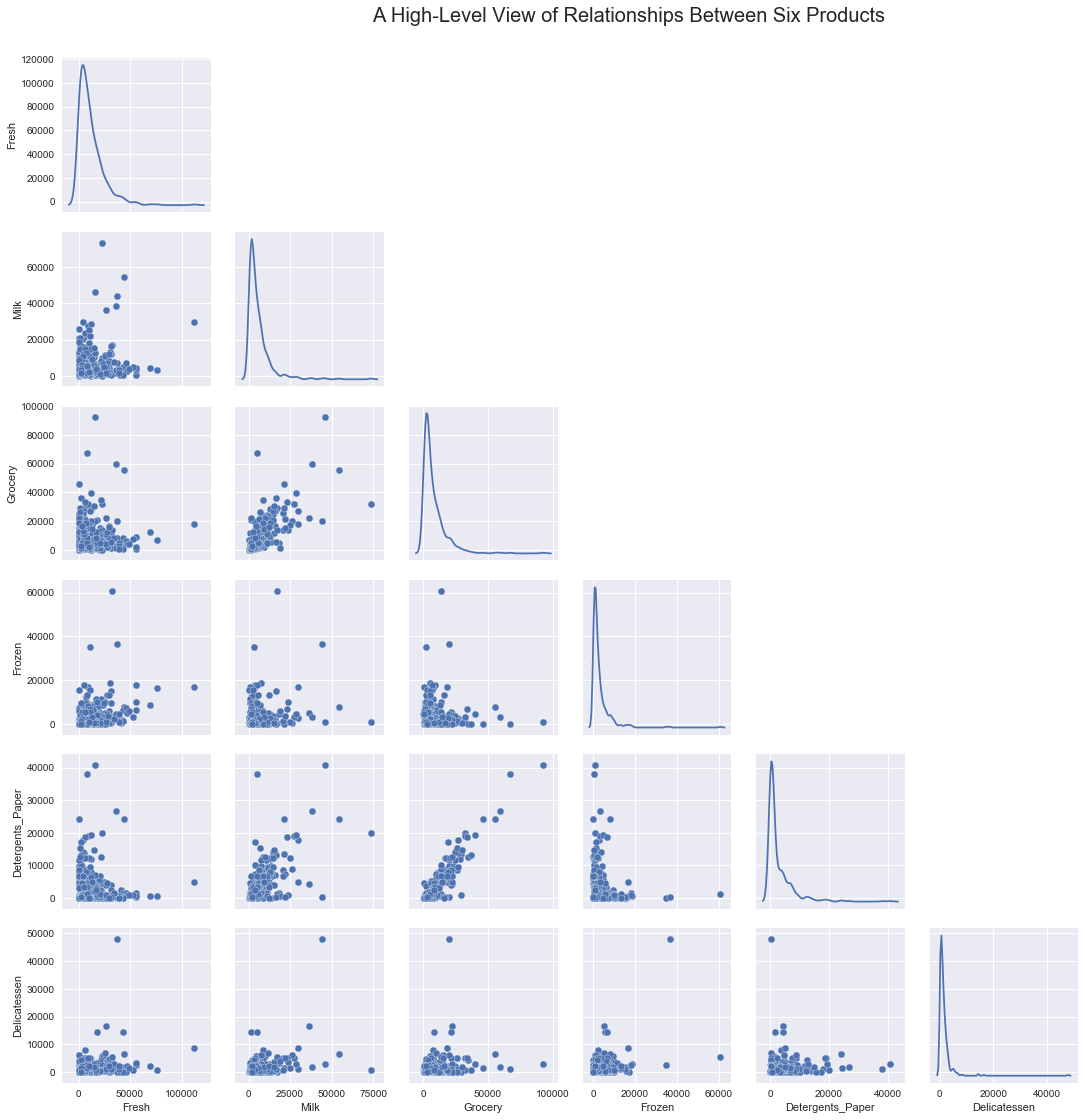

In [5]:
# Producing a scatter matrix for each pair of features in the data
viz.scttr_matrix(data,"scatter_matrix.png","Six Products")

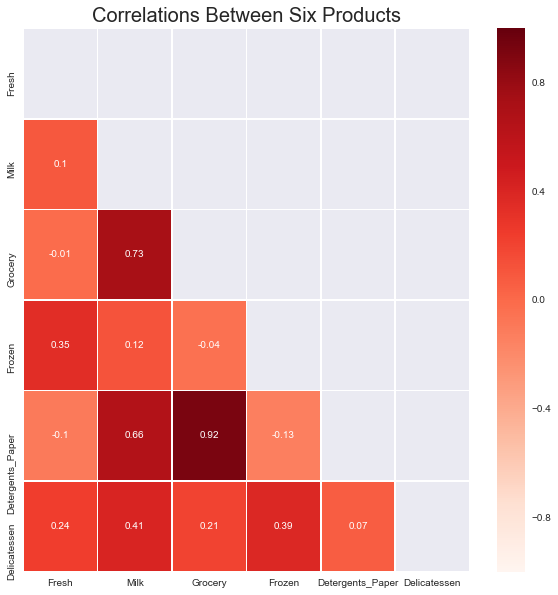

In [6]:
#Making a correlation heatmap
viz.make_corr_matrix(data, "corplot.png","Six Products")

### 3. Correlation and Normality
Based on the correlation matrix, spendings between grocery and detergents paper products are highly correlated to each other, while milk is correlated to detergent paper and grocery products mildly.   Because spendings on detergent paper products are are not strongly correlated to a lot of features, the correlation matrix confirms my previous assumption that detergent paper products would be an important feature when considering its relevance in identifying customer spendings. The scatter matrix also indicates that the data:
 * Has several outliers;
 * Is not normally distributed;and 
 * Has large numbers of data points mostly at the lower end of spendings for all six products.
 
Looking at the individual scatter plots between these moderately to highly correlated products also shows us positive relationships between them:

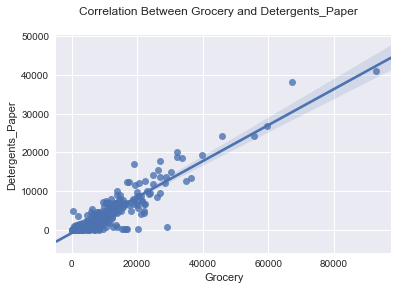

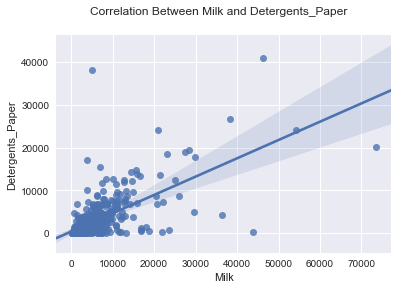

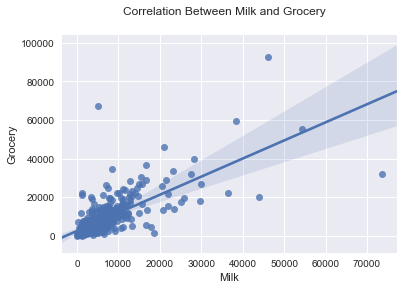

In [7]:
viz.make_reg_plt("Grocery", "Detergents_Paper", data, "plt1.png")
viz.make_reg_plt("Milk" , "Detergents_Paper", data, "plt2.png")
viz.make_reg_plt("Milk", "Grocery", data, "plt3.png")

## Data Preprocessing
In this section, I preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers.

### Implementation: Feature Scaling
Since data is not normally distributed, I transform it via natural logorithm.  

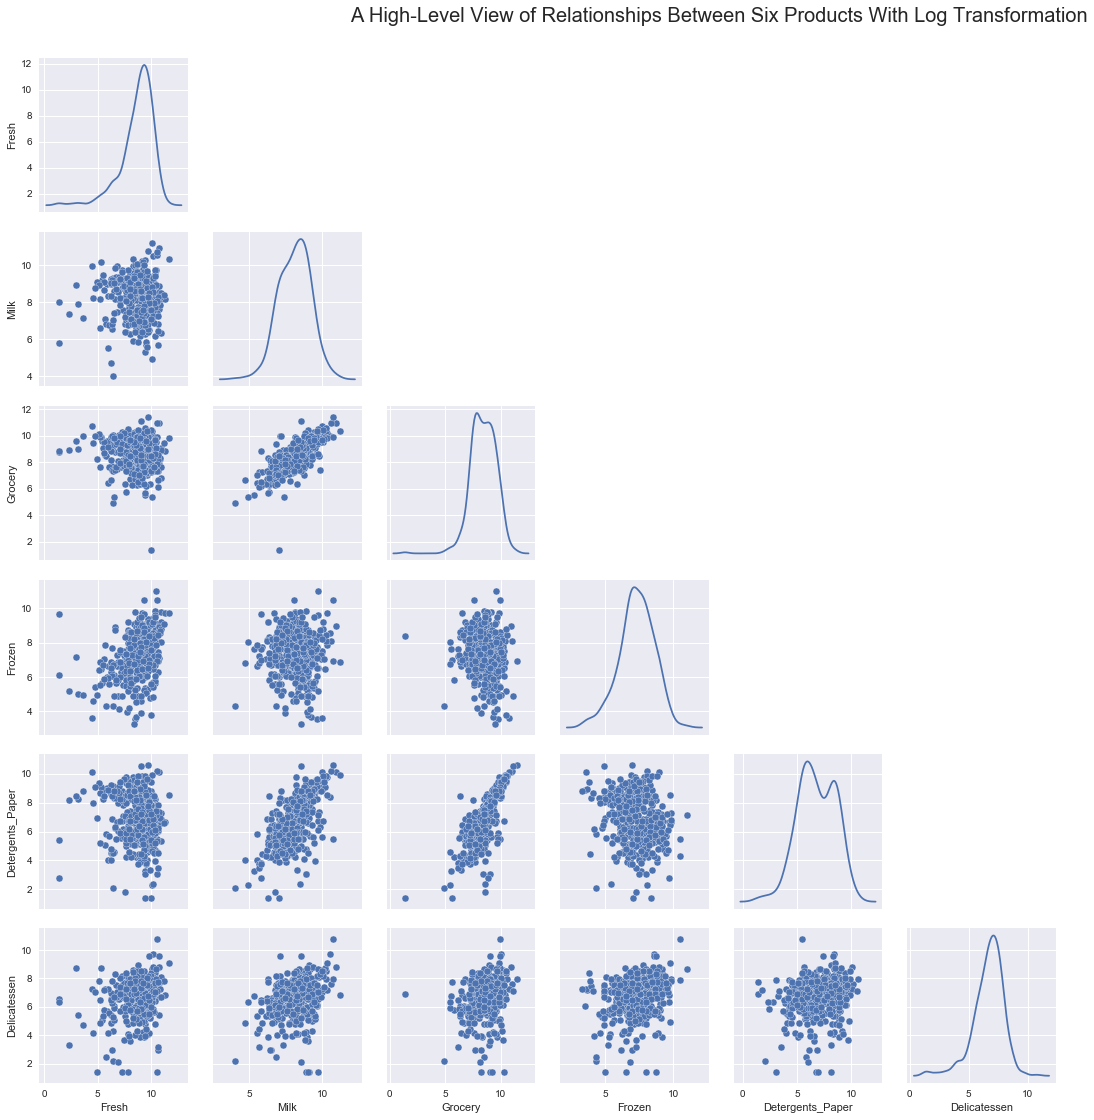

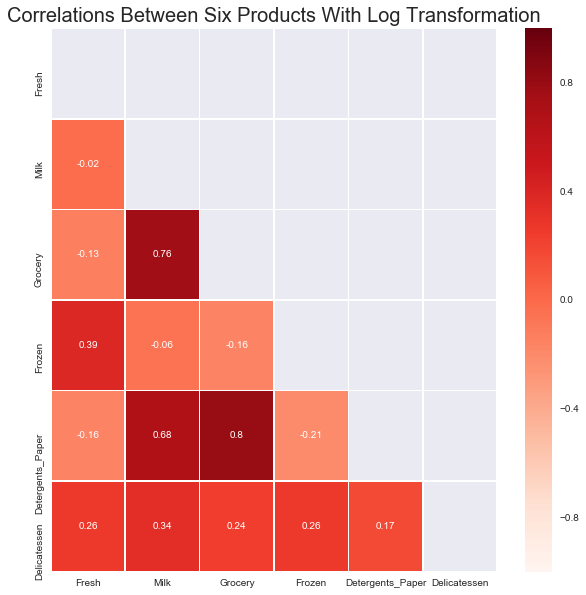

In [8]:
#Scaling the data using the natural logarithm
import transform as tr
log_data = data
tr.log_transform(log_data)

#print scatter matrix plot of log data
viz.scttr_matrix(log_data,"scatter_matrix_log.png","Six Products With Log Transformation")
print "\n"

#print correlation matrix of log data
viz.make_corr_matrix(data, "corplot_log.png","Six Products With Log Transformation")

### Observation
After applying natural logarithm transformation to the data, the data now appears more normal. In addition, spendings between grocery and detergents paper products are still highly correlated to each other, while spendings on milk and detergent paper products and milk and grocery products moderately correlated to each other.

In [9]:
# Display the log-transformed sample data
log_samples = samples
tr.log_transform(log_samples)
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,6.535241,8.611048,9.313979,6.726233,8.352319,6.079933
1,10.702503,10.901543,10.925435,8.959697,10.092950,8.774313
2,8.468213,7.113142,8.086718,8.222822,7.129298,7.044033


### 4. Outlier Detection
I use the Tukey's method of identifying outliers by flagging any data points that are above or below 1.5 times the interquartile range. Here are the indices and their corresponding features of the outliers.

In [10]:
import collections
outl = tr.detect_outliers(log_data)
for k,v in outl.items():
    print k,v

128 ['Delicatessen', 'Fresh']
193 ['Fresh']
264 ['Frozen']
137 ['Delicatessen']
142 ['Delicatessen']
145 ['Frozen']
154 ['Grocery', 'Delicatessen', 'Milk']
412 ['Fresh']
285 ['Delicatessen']
289 ['Delicatessen']
420 ['Frozen']
38 ['Frozen']
171 ['Fresh']
429 ['Frozen']
175 ['Frozen']
304 ['Fresh']
305 ['Fresh']
439 ['Frozen']
184 ['Delicatessen']
57 ['Frozen']
187 ['Delicatessen']
65 ['Frozen', 'Fresh']
66 ['Delicatessen', 'Fresh']
75 ['Grocery', 'Detergents_Paper']
325 ['Frozen']
161 ['Detergents_Paper']
203 ['Delicatessen']
81 ['Fresh']
338 ['Fresh']
86 ['Milk']
343 ['Delicatessen']
218 ['Fresh']
95 ['Fresh']
96 ['Fresh']
353 ['Fresh']
98 ['Milk']
355 ['Fresh']
356 ['Milk']
357 ['Fresh']
233 ['Delicatessen']
109 ['Delicatessen']
183 ['Delicatessen']


Several outliers are in multiple products, while others only entail one specific product.  A customer buying an extremely large amount of delicatessen products relative to other products, for example, could be a deli serving a big group of people for a speical occasion.  Similarly, a customer buying large amounts of grocery, milk, and delicatseen products could be a market stocking up for many other establishments and more people looking to buy a lot of food for special occasions like Thanksgiving and Christmas.  Therefore, these outliers, regardless of whether they are in one or multiple product categories, all represent anamolous events.  If I do not remove them from our data, they could all pull the centroids of K-means to an area that's not representative of these products' underlying distributions.  Furthermore, Gaussian Mixture Model (GMM) clustering is also sensitive to outliers, because calculating probabilstic scores for each data point in cluster assignment involves the mean of a given feature.  Hence, I remove all these outliers from the data, because leaving them in for either K-means or GMM clustering would probably give us clusters that are not representative of the products' underlying distributions.

In [11]:
#removing outliers from data
ind = []
for k,v in sorted(outl.items()):
    ind.append(k)
temp = log_data
good_data = temp.drop(temp.index[ind])

In [12]:
print "Wholesale customers dataset has {} samples with {} features each.".format(*good_data.shape)

Wholesale customers dataset has 398 samples with 6 features each.


## Feature Transformation
Since the correlation matrix reveals the relationship between two products, it's hard to gauge whether there are relationships between three or more products.  Principle component analysis (PCA) then becomes useful in drawing conclusions about the underlying structure of the wholesale customer data. Most businesses have large data sets with many dimensions or combinations of features describing facts and measures.  On one hand, analyzing data with many dimensions is not ideal due to practical limitations like memory and CPU time.  On the other hand, ignoring these dimensions could lead to information loss.  PCA then manages this tradeoff by keeping the most relevant directions that allow us to capture as much information as possible and then discarding those entailing mostly noise.  Since using PCA on a dataset calculates the dimensions which best maximize variance or best capture as much information as possible, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space; however it is a composition of the original features present in the data.

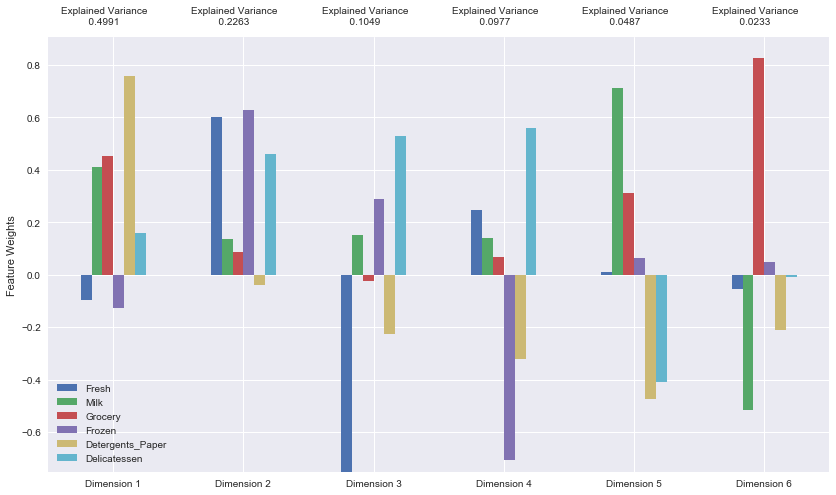

In [13]:
from sklearn.decomposition import PCA

#Applying PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=data.shape[1]).fit(good_data)
pca.fit(good_data)

#Transforming log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

### 5. Explained Variance and Feature Contribution In PCA Dimension

The first and the second dimensions  capture ~50%  and ~23% of the variance in the data, respectively, explaining ~73% of the variance in the data in total.  Since the first four dimensions then explain ~93% of the variance in the data altogether, they best describe customer spendings.  The feature weights in each dimension indicate a feature's contribution to the dimension.  

In the first dimension that explains ~50% of the variance in the data, detergent paper products have the *absolute* highest feature weight and thus the most influence on this dimension.  Because the feature weight for detergent paper products is positive, customers with extremely high positive scores in the first dimension would be those who mostly prefer detergent paper products over other products.  

In the second dimension that explains ~23% of the variance in the data, fresh, frozen, and delicatessen products have the highest *absolute* feature weights and thus have the most influence on this dimension.  Because their feature weights are positive, customers with extremely high positive scores in this dimension would be those who mostly prefer fresh, frozen, and delicatessen products over other products.

In the third dimension that explains ~10% of the variance in the data, fresh and delicatessen products have the highest *absolute* feature weights and thus have the most influence on this dimension.  Because fresh products' feature weight is negative, cutomers with very high negative scores in this demension would be those who mostly prefer fresh products over others.  Delicatessen products have a positive feature weight, so customers with very high positive scores in this dimension would be those who prefer delicattessen products over others.  

In the fourth dimension that explains ~10% of the variance in the data, frozen and delicatessen products have the highest *absolute* feature weights and thus have the most influence on this dimension.  Because frozen products have a negative feature weight, customers with highly negative scores in this dimension would be those preferring frozen products over others.  Delicatessen products have a postive feature weight, so customers with highly negative scores in this dimension would be those preferring delicatessen products over others.

In the fifth dimension that explains ~5% of the variance in the data, milk, detergent paper, and delicatessen products have the highest *absolute* feature weights and thus have the most influence on this dimension altogether.  Milk products have a positive feature weight, so customers with highly positive scores in this dimension would be those preferring milk products over others.  Detergent paper and delicatessen products have negative feature weights, so customers with very high negative scores would be those preferring detergent paper and delicatessen products over others.

In the sixth dimension that explains ~2% of the variance in the data, milk and grocery products have the highest *absolute* feature weights and thus have the most influence on this dimension.  Milk products have a negative feature weight, so customers with very high negative scores in this dimensoin would be those preferring milk products over others.  Grocery products have a positive feature weight, so customers with very high positive scores would be those preferring grocery products over others.  

Looking at the feature weights in all the dimensions then reveals possibly two distinct groups: customers who mostly prefer one type of products like those in the first dimension that mostly prefer detergent papers and customers who mostly prefer multiple products like those in second dimension and thereafter.  Knowing these insights, we can customize services to different groups of customers.  Those who mostly buy detergent papers, for example, may need customized delivery services like faster shipment times and would, then, be receptive to paying more for these types of delivery services. 

### Observation
We want to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions.

In [14]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,2.0010,-2.1358,0.9183,-0.8701,0.1113,0.2645
1,4.7229,3.4113,-0.2362,-0.0396,0.5029,-0.0981
2,-0.3275,0.1507,0.4856,-0.8111,-1.0329,0.2325


Observing the scores in the first four dimensions somewhat contradicts my initital interpretations of the sample points. A mix of positive and negative scores across all four dimensions indicates that all of these customers might required customized delivery serivces. 

### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.  Looking at the explained variances for all six dimensions in the previous plot, explained variance ratio's are the greatest in the first and second dimensions and then decrease slightly with each dimension after the second dimension.  The first and second dimensions, which explain ~73% of the data altogether, are then sufficient enough, since we're not capturing much information after the second dimension.  Therefore, I reapply PCA with two dimensions only.

In [15]:
# Applying PCA by fitting the good data with only two dimensions
pca = PCA(n_components = 2).fit(good_data)

# Transforming the good data using the PCA fit above
reduced_data = pca.transform(good_data) 

# Transforming log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Creating a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
We want to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. The value for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [16]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,2.0010,-2.1358
1,4.7229,3.4113
2,-0.3275,0.1507


## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

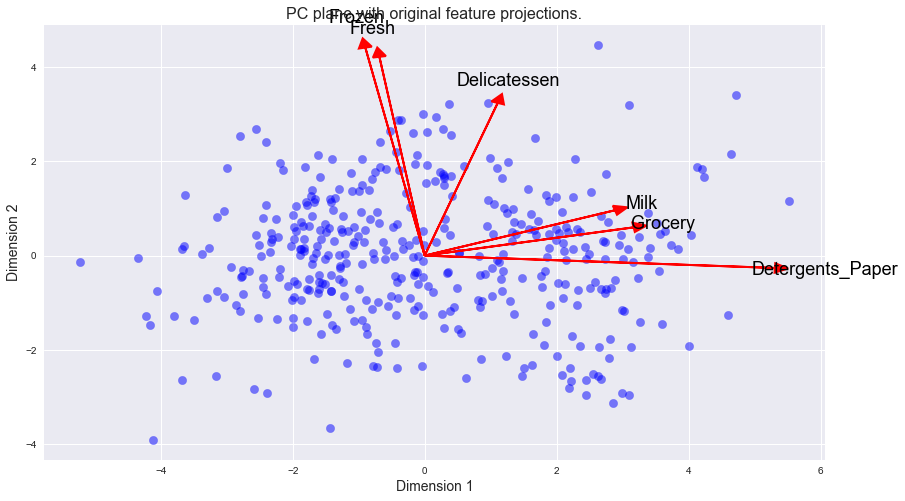

In [17]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### Observation

Looking at the biplot confirms my observations in the eariler pca_results plot and reveals two distinct groups of customers.  The first group of customers projects towards strong preference for detergent paper products. Within the first group, there seems to be a sub-group that prefers mostly milk and grocery products over others. The preferences for both milk and grocery products are strongly correlated, as indicated by the closeness of the arrows.  The second group of customers move towards strong preference for both fresh and frozen products.  The prefernces for both fresh and frozen products are also strongly correlated, as indicated by the closness of the arrows.  Within the second group, there also seems to be a sub-group of customers just preferring delicattessen products over others.  

## Clustering

In the last section, PCA enabled us to capture the majority of the information in the data and revealed underlying insights about different types of customers and their preferences via visualizations like the biplot.  We could then capture or visualize distinct groups of customers more intuively by breaking up PCA components into clusters. In this section, we will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. We will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### 6. K-Means Clustering vs. Gaussian Mixture Model Clustering

** K-Means Clustering - Overview **

K-means clustering divides data into a fixed number (k) of clusters.  A centroid is an imaginary or a real data point at the cluster's center.  Each data point is then assigned to the closest centroid, and a cluster entails a group of data points that are closest to the centroid.  Here are the steps taken by K-means:

1. Randomly initializing centroids and their respective clusters;
2. Assigning each data point to the closest centroid and its respective cluster based on the Euclidean distance between the centroid and the data point;
3. Calculating the mean of all data points in each cluster and moving its centroid to that average; and
4. Repeating steps 2 and 3 until all centroids stabalize -- that is, when data points are no longer assigned to different clusters.

** K-Means Clustering - Strenghts and Weaknesses **

On one hand, K-means is "one of the fastest clustering algorithms available"; it's also simple to implement. On the other hand, randomly initializing centroids could give us different centroids and their respective clustering, making cluster assignments uncertain.  Hence, k-means is very sensitive to initial centroid and cluster assignments and could produce many different solutions, especially when data points in clusters are more heterogenous or aren't spherically shaped.  Furthermore, the hard assignments of data points to specific clusters become problematic if there are distinct but smaller groups of data points that are very different from others.  Even though the data points in these groups are extremely far from a centroid compared to others, assigning them to a specific cluster just because they happen to be the closest to its centroid makes the cluster misleading, because the cluster then is not representative of these distinct but smaller groups of data points.  Mixture models address this problem via 'soft' assignment of data points to clusters based on probabilities.  But because K-means is fast and simple to implement, we could use it for pre-clustering purposes -- that is, dividing data points into sub-spaces where more sophisticated clustering algorithms could be applied.  

** Gaussian Mixture Model Clustering **

K-means's approach to clustering is known as hard clustering where one data point is assigned to exactly one cluster.  Unlike k-means, Gaussian Mixture Model (GMM) clustering takes a probabilistic approach in cluster assignments.  This flexible approach, known as soft clustering, assigns a data point to a cluster based on its probabistlic score that indicates the strength of its assocation to that cluster. Unlike K-means that's sensitive to clusters with hetergenous shapes, GMM is flexible enough to accomodate different shapes of clusters and potential correlations of data points within them.  Even though the GMM's run-time could be slower than K-means due to calculations of probabiltistic scores, GMM's flexible approach helps us capture uncertainities present in most real-world data.  Our previous observations of the wholesale data showed us that there are distinct groups and subgroups of customers who either prefer one or multiple products over others.  Given that there are sub-groups and correlations of preferences within groups, I pick GMM clustering to accomodate for these uncertanities in customers' preferences.  

### Implementation: Creating Clusters and Clustering Visualization
When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In [18]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.mixture import GMM
from sklearn.metrics import silhouette_score

for i in range(2,30):
    # Applying your clustering algorithm of choice to the reduced data- starting with 2 clusters
    clusterer = GMM(n_components=i).fit(reduced_data)

    #Predicting the cluster for each data point
    preds = clusterer.predict(reduced_data)

    #Finding the cluster centers
    centers = clusterer.means_

    # Predicting the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples)

    # Calculating the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data,preds)
    print i, "Clusters With A Mean Silhouette Coefficient of ", score
    
    

2 Clusters With A Mean Silhouette Coefficient of  0.443798970307
3 Clusters With A Mean Silhouette Coefficient of  0.357153332345
4 Clusters With A Mean Silhouette Coefficient of  0.292116871418
5 Clusters With A Mean Silhouette Coefficient of  0.268521841369
6 Clusters With A Mean Silhouette Coefficient of  0.31050212828
7 Clusters With A Mean Silhouette Coefficient of  0.298234136545
8 Clusters With A Mean Silhouette Coefficient of  0.298363001168
9 Clusters With A Mean Silhouette Coefficient of  0.294357518673
10 Clusters With A Mean Silhouette Coefficient of  0.26544992196
11 Clusters With A Mean Silhouette Coefficient of  0.240893211361
12 Clusters With A Mean Silhouette Coefficient of  0.188935662927
13 Clusters With A Mean Silhouette Coefficient of  0.200808503924
14 Clusters With A Mean Silhouette Coefficient of  0.116102596581
15 Clusters With A Mean Silhouette Coefficient of  0.134545116906
16 Clusters With A Mean Silhouette Coefficient of  0.173008346217
17 Clusters With A M

### 7.  Silhouette Scores
Two clusters have the highest silhouette score.

### Cluster Visualization
Once we've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, we can now visualize the results by executing the code block below.

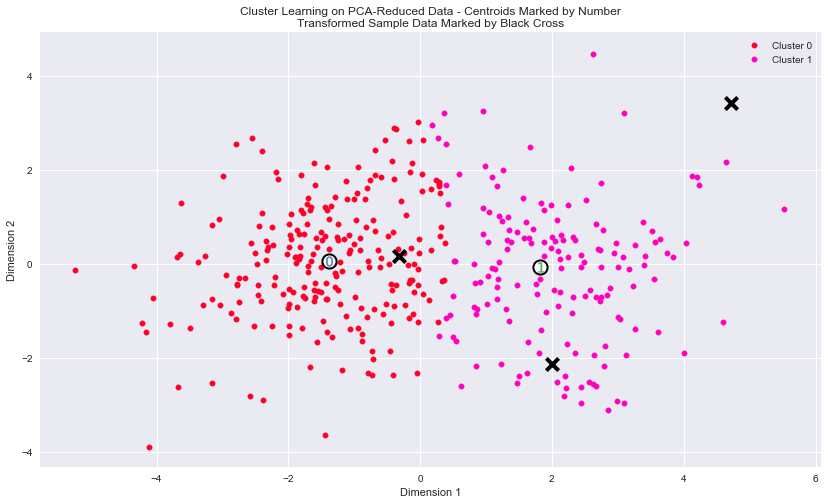

In [19]:
# Displaying the results of the clustering from implementation
clusterer = GMM(n_components=2).fit(reduced_data)
preds = clusterer.predict(reduced_data)
sample_preds = clusterer.predict(pca_samples)
centers = clusterer.means_
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In [20]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
#Inverse transform the centers
log_centers = pca.inverse_transform(centers)

#Exponentiating the centers
true_centers = np.exp(log_centers)

# Displaying the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
s = true_centers.style.background_gradient(cmap=cm)
display(s)

### 8.  Segmentation and Sample Customers
A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`. I apply color scale based on values of each field to get a better sense of what each cluster represents.  Cluster 0 contains customers who prefer fresh and frozen products over others.  Cluster 1 contains customers who prefer milk, grocery, detergent paper, and delicatessen products over others.  Therefore, cluster 1 probably represents chain retail establishments like Walmart grocery stores, while cluster 0 represents restaurants or establishments with cafes and restaurants like hotels or motels.  Looking the mean spendings on customer segments to the sample customers' spendings, sample customers 0 and 1 spend  relatively more on milk, grocery, detergent paper, and delicatessen products compared to sample customer 2 and  are probably chain retail stores like Safeway or Walgreens.  Sample customer 2 spends more on fresh and frozen products than other products and is probably a restaurant or an establishment with restaurants.  

### 9. Predicting Customer Segment

In [21]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 0


Comparing the cluster means with the sample customers' spendings each product, customers 0 and 1 represent chaine retail stores (cluster 1) and sample customer 2 represents restaurants or an establisment with restaurants (cluster 0).  The predictions for each sample customer are cosistent with earlier observations.  

## Conclusion

In this final section, I will investigate ways that we can make use of the clustered data. First, I will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, I will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, I will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### 10.  Experimental Design

The wholesale distributor could consider changing its delivery service from currently 5 days a week to 3 days a week based on the customer segments. However, the distributor will only make this change in delivery service for customers that react positively. In order to determine which customers could react positively to the change in delivery services, the wholsesale distributor could first pick random customers who are close to the center of the clusters, since they represent the typical customers of the clusters.  Then there will be two similar groups of these randomly chosen customers for each cluster: the first group (control group) will consist of those who currently have the 5 days a week delivery service and the second group (experimental group) will consist of those whose delivery services are switched to 3 days a week.  Afterward, we can calculate the sample size for each group needed for the experimental design results to be statistically significant.  Finally, we can get customers' reactions ( positive or negative) to their delivery services for each group and then apply hypothesis testing to these groups to determine if changing delivery services from 5 days to 3 days influence customers' reactions.  

### 11. Predicting Customer Segment
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider **customer segment** as an **engineered feature** for the data. Assuming the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor could classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  

We could project the predicted spendings of future customers to PCA space, apply GMM clustering, and then look at how close they are to the cluster centers to determine which initial delivery services would be appropriate for them.  In addition, we would have the data on customers' reactions to delivery changes from the experimental design in section 10.  Having this information would then allow us to predict future customers' reactions to delivery changes using supervised learners like logistic regression or random forest.  Therefore, a customer's reaction would be the target variable, and spendings on products and customer segments would be the input variables for these supervised learners. 

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

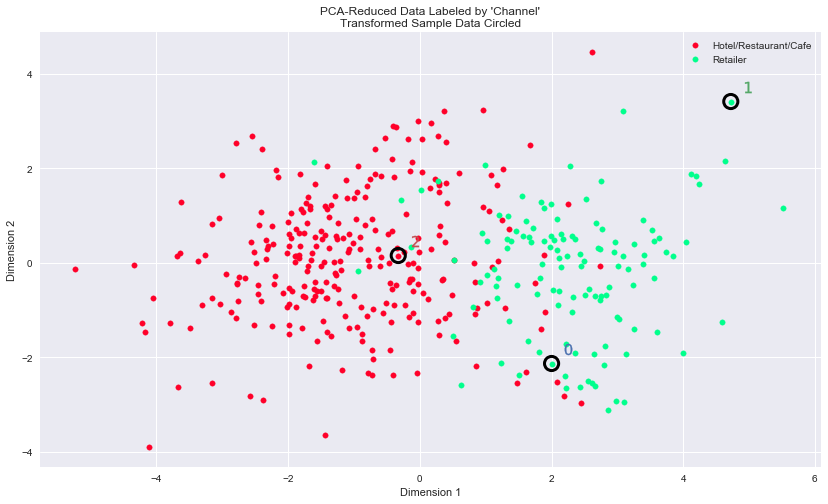

In [22]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, ind, pca_samples)

### 12.  Underlying Distributions vs. Clustering

GMM clustering I've chosen is adequate compared to the underlying distribution, since there are two distinct groups in the underlying distribution.  Because there are only two groups that are either hotels/restaurants/cafe's or retailers in the graph, these classifications are consistent with my previous definition of the customer segments. Customer segment 1 could be classified as retailers on the right side of the graph.  Customer segment 0 could be classified as hotels, cafes, or restaurants on the left side of the graph.  However, adding the 'Region' variable into the underlying distribution could also reveal different subgroups of hotels, restaurants, cafes, and retailers whose spendings reflect the regions they serve.

## Sources

http://pareonline.net/getvn.asp?v=20&n=2

http://www.tqmp.org/Content/vol09-2/p079/p079.pdf

https://statistics.laerd.com/spss-tutorials/principal-components-analysis-pca-using-spss-statistics.php

http://dni-institute.in/blogs/k-means-clustering-algorithm-explained/

http://scikit-learn.org/stable/documentation.html

https://www.coursera.org/specializations/machine-learning

https://blog.hubspot.com/marketing/email-a-b-test-sample-size-testing-time